In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# 1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
# 2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers) за допомогою (наприклад) Pipeline модуля

In [2]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

In [3]:
input_text = "Have you ever been to"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
output = model.generate(input_ids, max_length=50, num_return_sequences=1)
print(tokenizer.decode(output[0], skip_special_tokens=True)[:142])

Have you ever been to a party where you're not sure what to do?

I've been to parties where you're not sure what to do.

I've been to parties 


In [4]:
from transformers import pipeline

In [5]:
classifier = pipeline("text-classification",
                       model="ukr-detect/ukr-toxicity-classifier")

text = "я сходив в магазин за хлібом"

result = classifier(text)
print(result)


[{'label': 'neutral', 'score': 0.9982836246490479}]


# 3. Завдання щодо генерації або стилізації зображень (на вибір)
# Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).

In [1]:
import  tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

GEN = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
DISC = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
GAN = tf.keras.Sequential([GEN, DISC])

In [9]:
DISC.compile(loss="binary_crossentropy", optimizer="rmsprop")
DISC.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="rmsprop")

batch_size = 2048
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gen_model, disc_model = GAN.layers
for epoch in range(30):
    print(f"Epoch {epoch + 1}/10")
    for real_data in dataset:
        # Discriminator
        noise_input = tf.random.normal([batch_size, 30])
        fake_data = gen_model(noise_input)
        combined_data = tf.concat([fake_data, real_data], axis=0)
        labels_disc = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
        disc_model.train_on_batch(combined_data, labels_disc)
        # Generator
        noise_input = tf.random.normal([batch_size, 30])
        labels_gan = tf.constant([[1.0]] * batch_size)
        GAN.train_on_batch(noise_input, labels_gan)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/10
Epoch 12/10
Epoch 13/10
Epoch 14/10
Epoch 15/10
Epoch 16/10
Epoch 17/10
Epoch 18/10
Epoch 19/10
Epoch 20/10
Epoch 21/10
Epoch 22/10
Epoch 23/10
Epoch 24/10
Epoch 25/10
Epoch 26/10
Epoch 27/10
Epoch 28/10
Epoch 29/10
Epoch 30/10


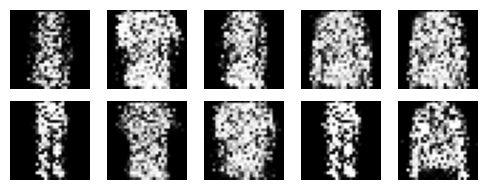

In [12]:
plt.figure(figsize=(5, 2))
for idx, image in enumerate(fake_data.numpy()[:10]):
    plt.subplot(2, 5, idx + 1)
    if image.shape[-1] == 1:
        image = image.squeeze(-1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()